# Deadlines aus Simulation (FIFO)

In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

from src.utils.production_process import initialize as init

# Extern
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.min_rows', 16)
pd.set_option('display.max_rows', 24)

In [2]:
basic_data_path = get_path("data", "basic")

df_jobs_times  = pd.read_csv(basic_data_path / "jobs_times_50_raw.csv")
df_jobs_times 

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time
0,0,0,51,1440,3050.0,395
1,1,1,136,1440,2736.0,510
2,2,2,158,1440,2258.0,568
3,3,3,236,1440,2926.0,655
4,4,4,404,1440,3007.0,393
5,5,5,485,1440,2731.0,496
6,6,6,501,1440,2646.0,416
7,7,7,528,1440,3085.0,539
...,...,...,...,...,...,...
969,969,9,71474,72000,73619.0,540


## 2) Log-Normalverteilung

In [3]:
def plot_random_deadline_distributions(df, n=3, seed=42, steps=1440, tick_interval=2880):
    """
    Plots histogram distributions of scattered deadlines for n evenly spaced jobs.
    Each subplot shows its own x–axis labels and title.
    
    Parameters:
    - df: DataFrame with columns 'Job', 'Deadline_List', 'Arrival', 'Ready Time', 'End'
    - n: number of jobs to plot (default 3)
    - seed: random seed for reproducibility
    - steps: step size for computing x_max (default 1440)
    - tick_interval: spacing between x–ticks (default 2880)
    """
    np.random.seed(seed)

    # sort & pick n evenly spaced jobs
    df_sorted = df.sort_values("Arrival").reset_index(drop=True)
    total = len(df_sorted)
    n = min(n, total)
    indices = np.linspace(0, total - 1, n, dtype=int)
    df_plot = df_sorted.iloc[indices].sort_values("Production_Plan_ID")

    # determine global x range & ticks
    x_max = max(max(lst) for lst in df_plot["Deadline_List"])
    x_ticks = np.arange(0, x_max + steps, tick_interval)

    # create subplots (no sharex) with ample size
    fig, axes = plt.subplots(n, 1, figsize=(14, n * 3.5))
    if n == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, df_plot.iterrows()):
        # histogram
        ax.hist(row["Deadline_List"], bins=50, density=True, alpha=0.7, color="orange")
        # vertical markers
        ax.axvline(row["Arrival"], color="blue", linestyle="--", linewidth=1, label="Arrival Time")
        ax.axvline(row["Ready Time"], color="green", linestyle="--", linewidth=2, label="Ready Time")
        ax.axvline(row["Ready Time"] + row["Processing Time"], color="orange", linestyle="--", linewidth=2, label="Earliest End")
        ax.axvline(row["End"], color="red", linestyle="--", linewidth=2, label="End")

        # titles & labels
        ax.set_title(f'Production_Plan {row["Production_Plan_ID"]} - Job {row["Job"]}')
        ax.set_ylabel("Dichte")
        ax.set_xlabel("Gestreute Deadline")
        ax.set_xticks(x_ticks)
        ax.tick_params(axis="x", labelrotation=90, labelsize=8, labelbottom=True)
        ax.set_xlim(0, x_max)

        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


In [4]:
def add_deadline_list_from_fn(df: pd.DataFrame, base_fn, k: int = 5, seed: int = 42, **base_fn_kwargs) -> pd.DataFrame:
    """
    Erzeugt für jeden Job eine Liste von k Deadlines, indem die gegebene Funktion
    mehrfach mit unterschiedlichen Seeds aufgerufen wird.

    Parameter:
    - df (pd.DataFrame): DataFrame mit Spalte 'Deadline', wie von base_fn erzeugt
    - base_fn (callable): Funktion, die df und base_fn_kwargs entgegennimmt
                          und eine DataFrame mit Spalte 'Deadline' zurückgibt
    - k (int): Anzahl der Szenarien / Läufe pro Job
    - seed (int): Basis-Seed; die Läufe verwenden seed, seed+1, ..., seed+k-1
    - **base_fn_kwargs: weitere Parameter, die an base_fn übergeben werden

    Rückgabe:
    - pd.DataFrame: Kopie von df mit neuer Spalte 'Deadline_List' (List[int])
    """
    df_temp = df.copy()
    all_deadlines = []

    # k Läufe generieren
    for i in range(k):
        df_run = base_fn(df_temp, seed=seed + i, **base_fn_kwargs)
        all_deadlines.append(df_run["Deadline"].tolist())

    # Transponieren: pro Zeile eine Liste aus den k Werten
    n_rows = len(df_temp)
    deadline_list = [
        [all_deadlines[j][row_idx] for j in range(k)]
        for row_idx in range(n_rows)
    ]

    df_temp["Deadline_List"] = deadline_list
    return df_temp

### A) Lognormalverteilte Multiplikation von End-Zeiten zur Deadline-Erzeugung

In [5]:
def add_lognormal_deadlines_a(df: pd.DataFrame, sigma: float = 0.2, seed: int = 42) -> pd.DataFrame:
    """
    Fügt einem DataFrame eine Deadline-Spalte hinzu, basierend auf lognormalverteilten Faktoren multipliziert mit 'End'.

    Parameter:
        df (pd.DataFrame): DataFrame mit Spalte 'End'
        sigma (float): Standardabweichung der zugrunde liegenden Normalverteilung
        seed (int): Seed für Zufallszahlengenerierung

    Rückgabe:
        pd.DataFrame: Kopie des DataFrames mit zusätzlicher Spalte 'Deadline'
    """
    df_temp = df.copy()
    np.random.seed(seed)
    factors = np.random.lognormal(mean=0, sigma=sigma, size=len(df_temp))
    df_temp["Deadline"] = np.ceil(df_temp["End"] * factors).astype(int)
    return df_temp

df_with_deadlines_a = add_lognormal_deadlines_a(df_jobs_times, sigma=0.2)
df_with_deadlines_a    

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,0,0,51,1440,3050.0,395,3369
1,1,1,136,1440,2736.0,510,2662
2,2,2,158,1440,2258.0,568,2571
3,3,3,236,1440,2926.0,655,3968
4,4,4,404,1440,3007.0,393,2870
5,5,5,485,1440,2731.0,496,2607
6,6,6,501,1440,2646.0,416,3629
7,7,7,528,1440,3085.0,539,3597
...,...,...,...,...,...,...,...
969,969,9,71474,72000,73619.0,540,55299


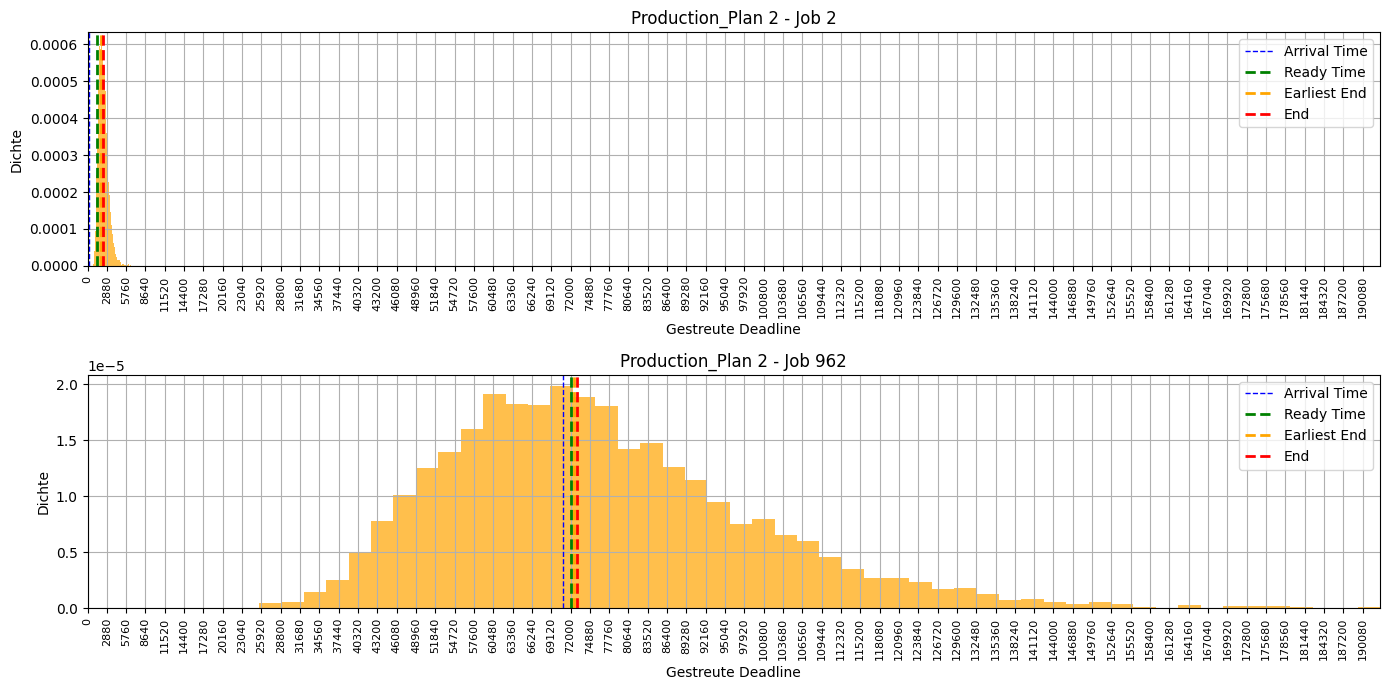

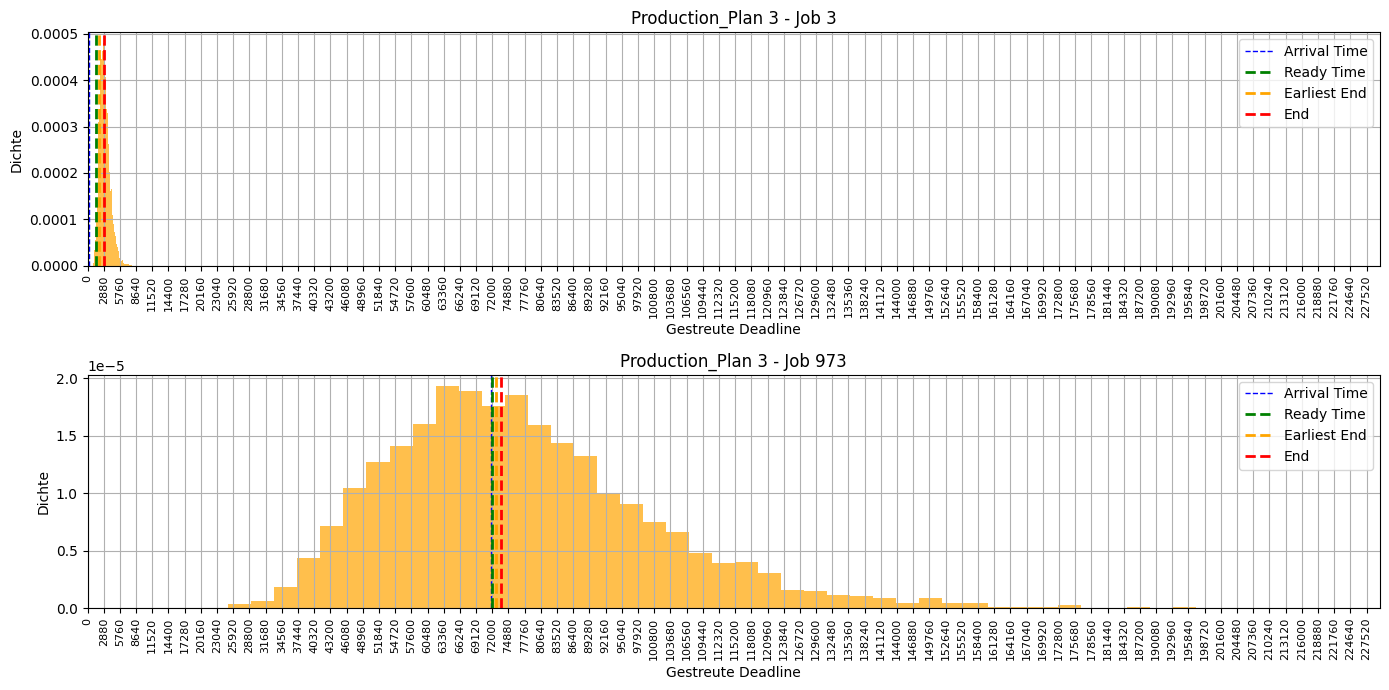

In [6]:
df = add_deadline_list_from_fn(df_jobs_times, base_fn=add_lognormal_deadlines_a,
                                          k=5000, seed=42, sigma=0.3)

filt = df.Production_Plan_ID.astype(str) == "2"
plot_random_deadline_distributions(df[filt], n=2)

filt = df.Production_Plan_ID.astype(str) == "3"
plot_random_deadline_distributions(df[filt], n=2)

### B) Lognormalverteilte Deadlines aus globalem mittleren End-Wert, verschoben auf individuelle End-Werte

In [7]:
def add_lognormal_deadlines_b(df: pd.DataFrame, sigma: float = 0.2, seed: int = 42) -> pd.DataFrame:
    """
    Fügt dem DataFrame eine 'Deadline'-Spalte hinzu, indem lognormalverteilte Zufallswerte
    mit Erwartungswert ≈ mean(End) erzeugt und differenziell zu jedem End-Wert addiert werden.

    Die Formel lautet:
        Deadline_i = End_i + (Z_i - mean_end), wobei Z_i ~ LogNormal(mu, sigma)

    Dadurch bleibt die Gesamtverteilung um End erhalten, aber mit asymmetrischer Streuung.
    """
    df_copy = df.copy()
    np.random.seed(seed)

    mean_end = df_copy["End"].mean()
    mu = np.log(mean_end) - 0.5 * sigma**2

    # Lognormalverteilte Zufallswerte mit Erwartung ≈ mean_end
    samples = np.random.lognormal(mean=mu, sigma=sigma, size=len(df_copy))

    # Deadline = End + (Sample - mean_end)
    df_copy["Deadline"] = (df_copy["End"] + (samples - mean_end)).round(1)

    return df_copy

df_with_deadlines_b = add_lognormal_deadlines_b(df_jobs_times, sigma=0.2)
df_with_deadlines_b

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,0,0,51,1440,3050.0,395,6216.8
1,1,1,136,1440,2736.0,510,951.4
2,2,2,158,1440,2258.0,568,6697.5
3,3,3,236,1440,2926.0,655,15552.2
4,4,4,404,1440,3007.0,393,527.8
5,5,5,485,1440,2731.0,496,251.9
6,6,6,501,1440,2646.0,416,15848.3
7,7,7,528,1440,3085.0,539,8561.6
...,...,...,...,...,...,...,...
969,969,9,71474,72000,73619.0,540,63505.1


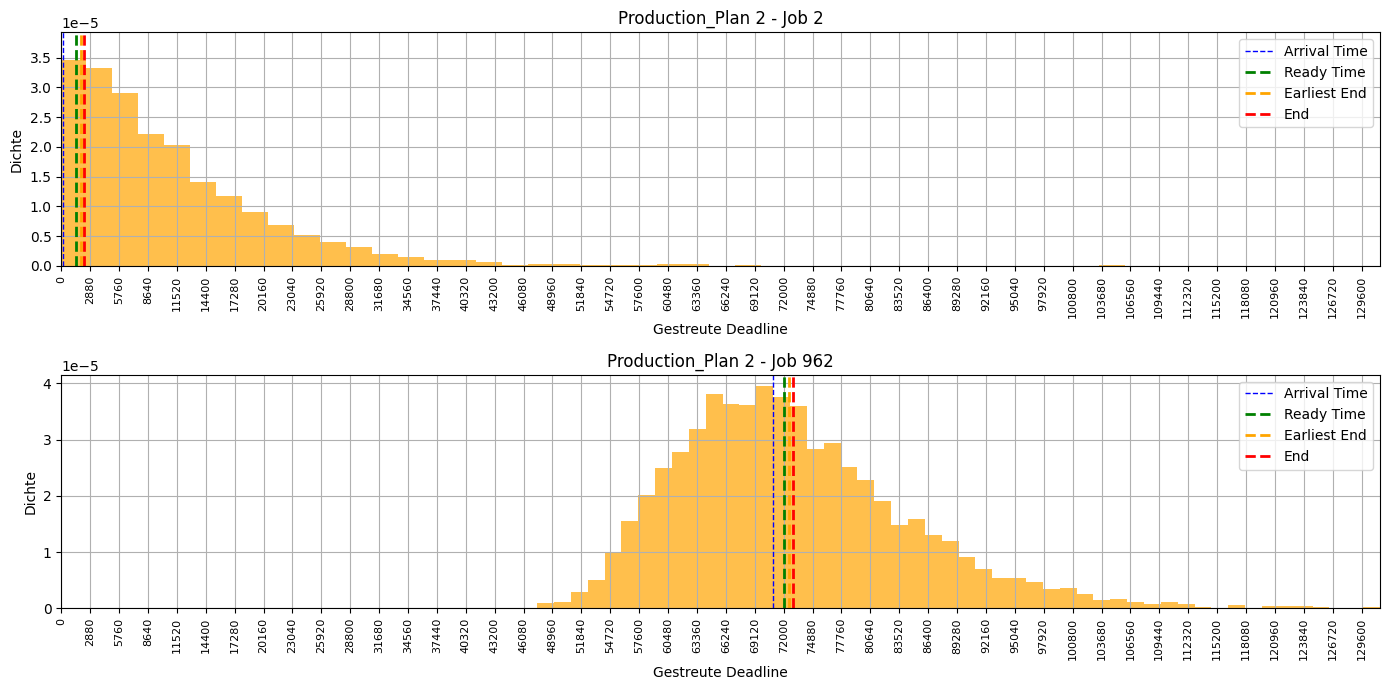

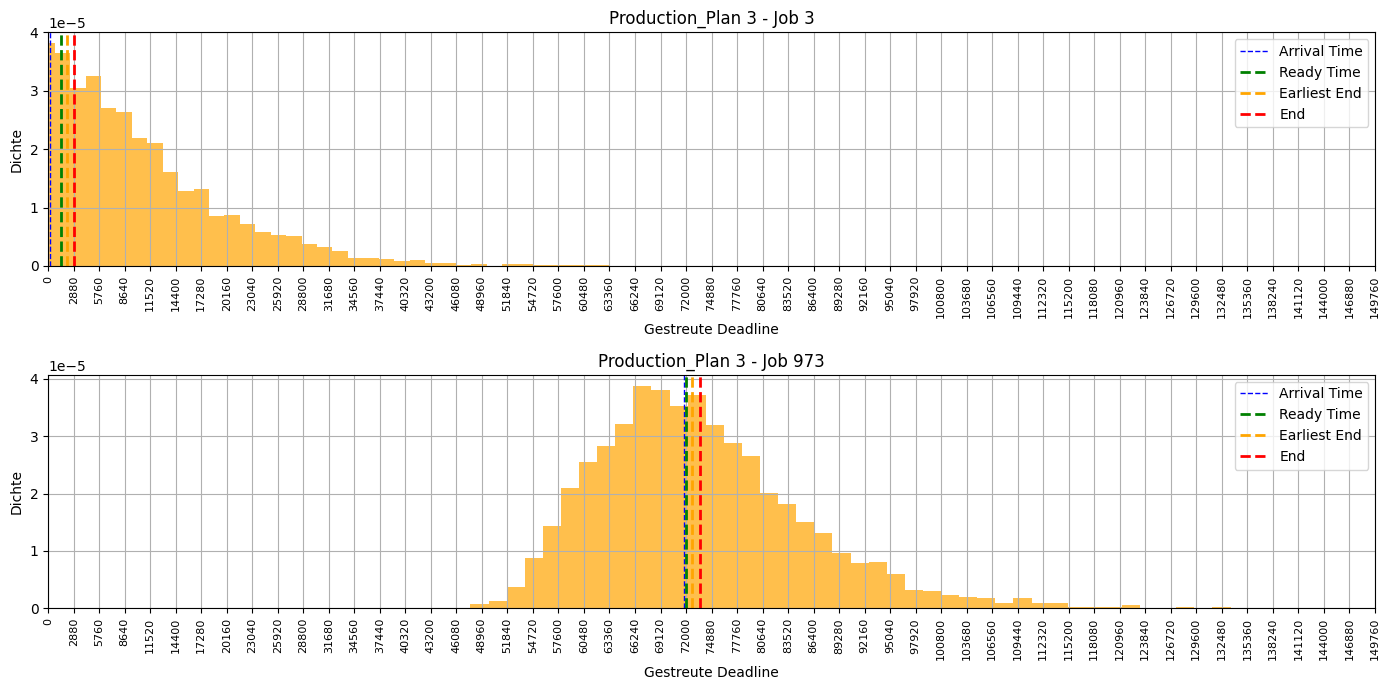

In [8]:
df = add_deadline_list_from_fn(df_jobs_times, base_fn=add_lognormal_deadlines_b,
                                          k=5000, seed=42, sigma=0.3)

filt = df.Production_Plan_ID.astype(str) == "2"
plot_random_deadline_distributions(df[filt], n=2)

filt = df.Production_Plan_ID.astype(str) == "3"
plot_random_deadline_distributions(df[filt], n=2)

### C) Lognormalverteilte Deadlines je Produktionsplan, direkt aus Gruppenmittelwert erzeugt

In [9]:
def add_groupwise_lognormal_deadlines_c(df: pd.DataFrame, sigma: float = 0.2, seed: int = 42) -> pd.DataFrame:
    """
    Fügt Deadlines hinzu, die direkt aus einer lognormalen Verteilung mit Erwartungswert = mean(End) pro Gruppe gezogen werden.
    """
    np.random.seed(seed)
    df_temp = df.copy()
    df_temp["Deadline"] = np.nan  # Leere Spalte vorbereiten

    for plan_id, group in df_temp.groupby("Production_Plan_ID"):
        n = len(group)
        mean_end = group["End"].mean()

        # Berechne μ so, dass E[X] = mean_end
        mu = np.log(mean_end) - 0.5 * sigma**2

        # Ziehe Deadlines direkt aus lognormaler Verteilung
        deadlines = np.random.lognormal(mean=mu, sigma=sigma, size=n)

        # Runde und eintragen
        df_temp.loc[group.index, "Deadline"] = np.round(deadlines, 1)

    return df_temp


df_with_deadlines_c = add_groupwise_lognormal_deadlines_c(df_jobs_times, sigma=0.2)
df_with_deadlines_c

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,0,0,51,1440,3050.0,395,41569.0
1,1,1,136,1440,2736.0,510,37295.7
2,2,2,158,1440,2258.0,568,40207.8
3,3,3,236,1440,2926.0,655,33484.1
4,4,4,404,1440,3007.0,393,31653.2
5,5,5,485,1440,2731.0,496,52806.8
6,6,6,501,1440,2646.0,416,33865.8
7,7,7,528,1440,3085.0,539,41715.9
...,...,...,...,...,...,...,...
969,969,9,71474,72000,73619.0,540,25870.0


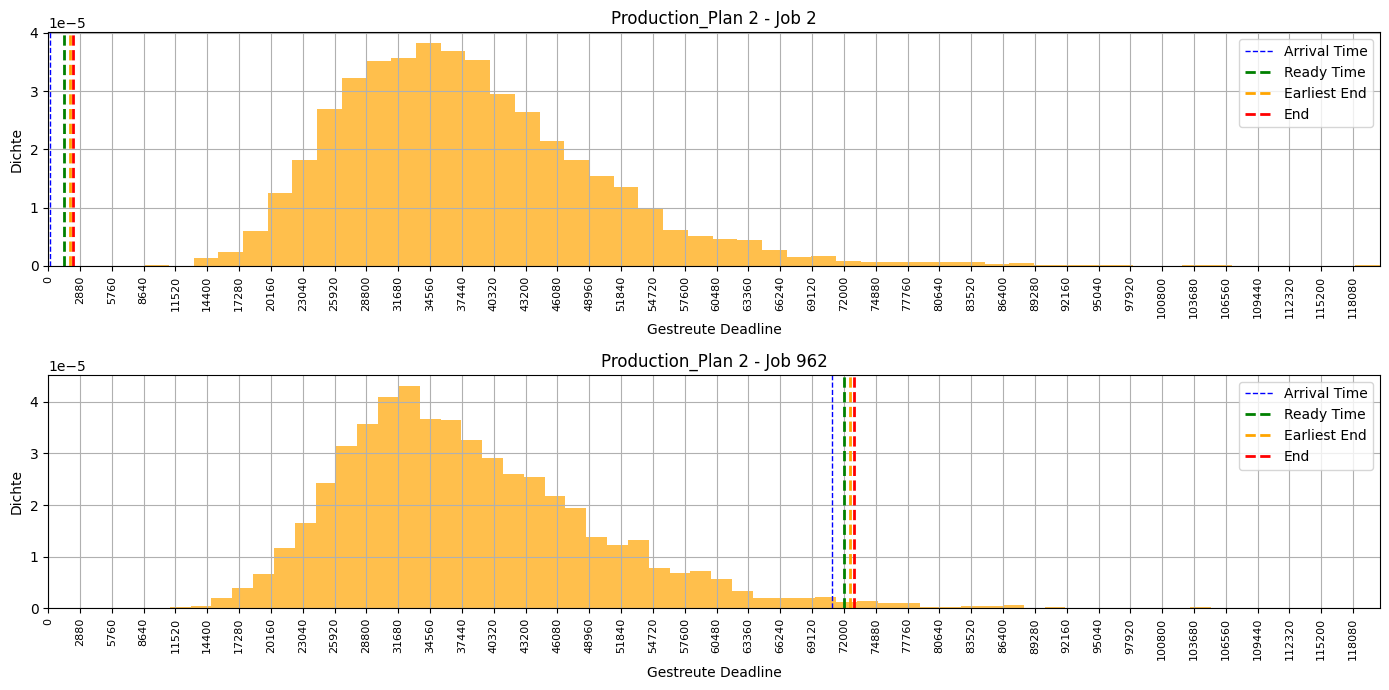

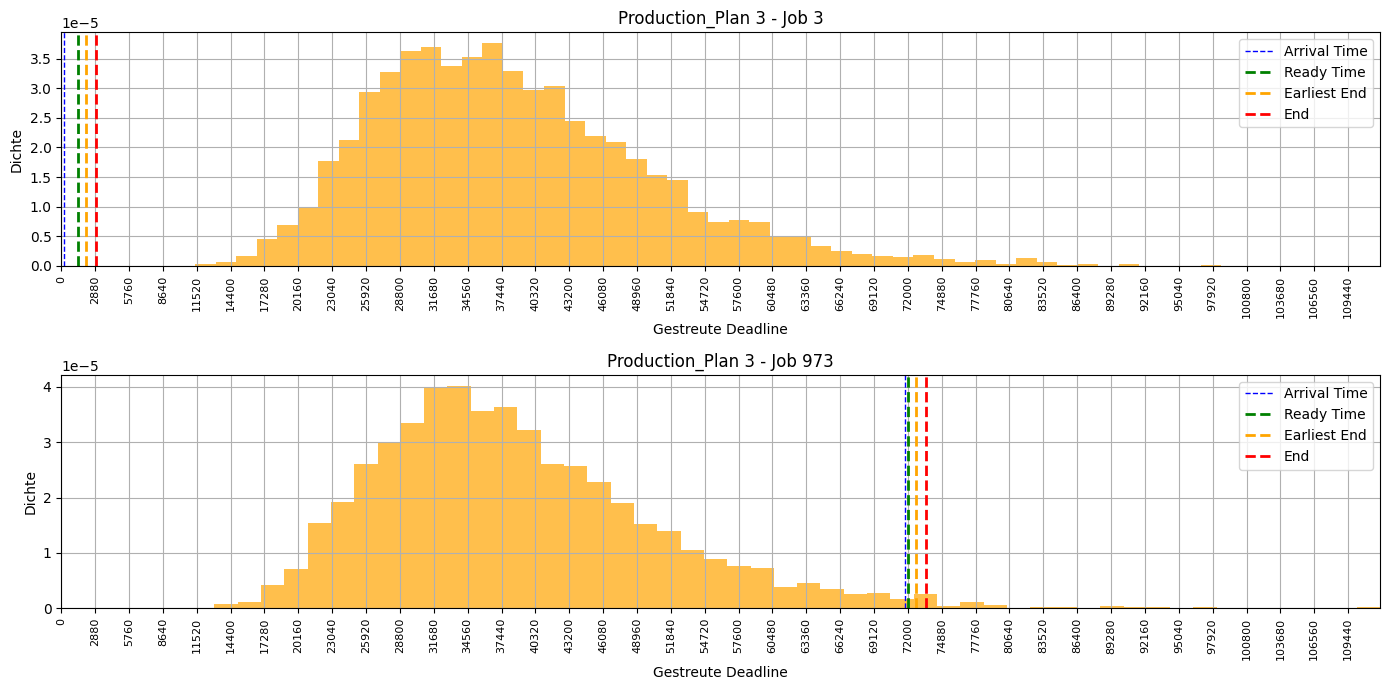

In [10]:
df = add_deadline_list_from_fn(df_jobs_times, base_fn=add_groupwise_lognormal_deadlines_c,
                                          k=5000, seed=42, sigma=0.3)

filt = df.Production_Plan_ID.astype(str) == "2"
plot_random_deadline_distributions(df[filt], n=2)

filt = df.Production_Plan_ID.astype(str) == "3"
plot_random_deadline_distributions(df[filt], n=2)

### D) Lognormalverteilte Deadlines je Produktionsplan, verschoben auf individuelle End-Werte

In [11]:
import numpy as np
import pandas as pd

def add_groupwise_lognormal_deadlines(df: pd.DataFrame, sigma: float = 0.2, seed: int = 42, method: str = 'mean') -> pd.DataFrame:
    """
    Fügt lognormal-verteilte Deadlines hinzu:
        Deadline = End + (sample - mean_end)

    Dabei wird für jede Gruppe ('Production_Plan_ID'):
      mean_end = group['End'].mean()

    Und je nach Methode:
      - method='mean':   E[X] = mean_end
                         → mu = ln(mean_end) - σ²/2
      - method='mode':   mode(X) = mean_end
                         → mu = ln(mean_end) + σ²

    Args:
        df:     DataFrame mit Spalten 'Production_Plan_ID' und 'End'
        sigma:  Lognormal-Standardabweichung
        seed:   Seed für den Zufalls-Generator
        method: 'mean'  → Erwartungswert = mean_end,
                'mode'  → Modalwert = mean_end

    Returns:
        df mit neuer Spalte 'Deadline' (float, 1 Dezimalstelle)
    """
    np.random.seed(seed)
    df_temp = df.copy()
    df_temp['Deadline'] = np.nan

    for plan_id, group in df_temp.groupby('Production_Plan_ID'):
        mean_end = group['End'].mean()
        if method == 'mean':
            # Erwartungswert = mean_end
            mu = np.log(mean_end) - 0.5 * sigma**2
        elif method == 'mode':
            # Modalwert = mean_end
            mu = np.log(mean_end) + sigma**2
        else:
            raise ValueError("Methode muss 'mean' oder 'mode' sein.")

        # Lognormal-Samples ziehen und um mean_end verschieben
        samples = np.random.lognormal(mean=mu, sigma=sigma, size=len(group))
        shifted = group['End'].values + (samples - mean_end)

        df_temp.loc[group.index, 'Deadline'] = np.round(shifted, 1)

    return df_temp

In [12]:
df_times = add_groupwise_lognormal_deadlines(df_jobs_times, sigma=0.2, method= "mode")
df_times

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,0,0,51,1440,3050.0,395,8791.2
1,1,1,136,1440,2736.0,510,4327.7
2,2,2,158,1440,2258.0,568,6974.5
3,3,3,236,1440,2926.0,655,46.6
4,4,4,404,1440,3007.0,393,-2031.5
5,5,5,485,1440,2731.0,496,20358.9
6,6,6,501,1440,2646.0,416,731.5
7,7,7,528,1440,3085.0,539,8789.9
...,...,...,...,...,...,...,...
969,969,9,71474,72000,73619.0,540,62575.9


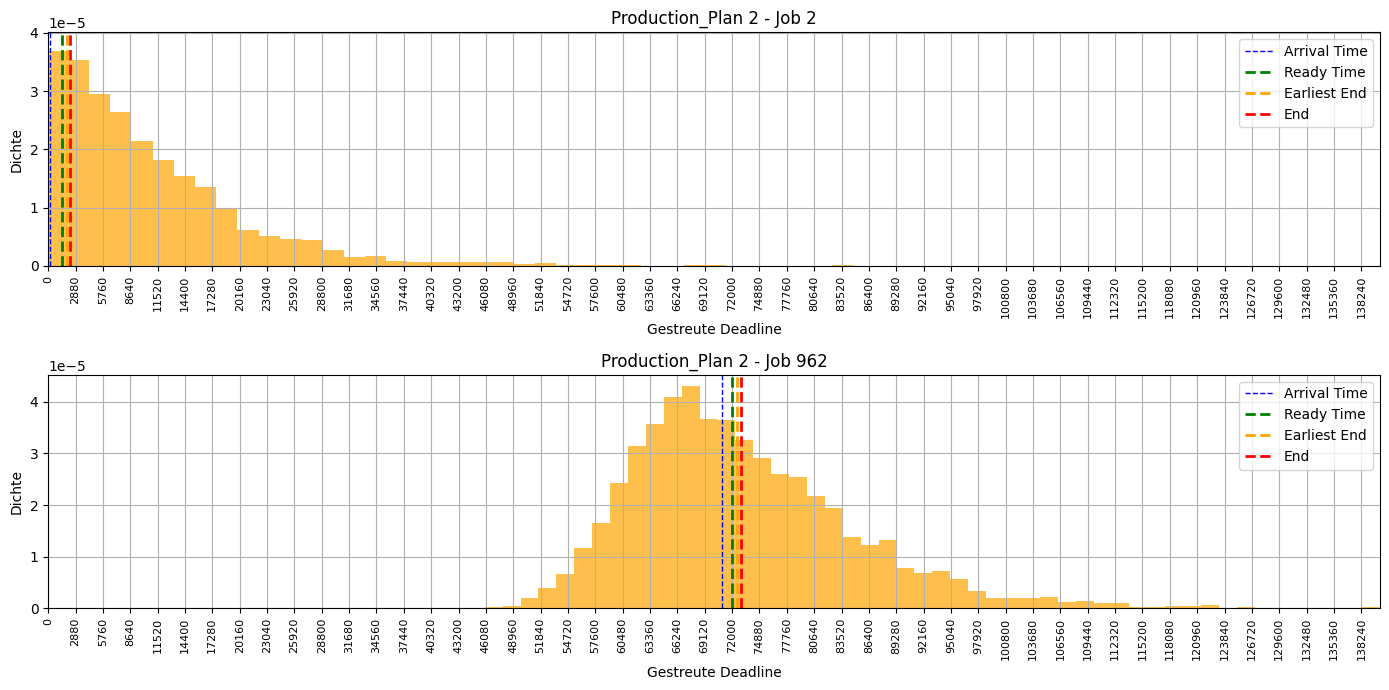

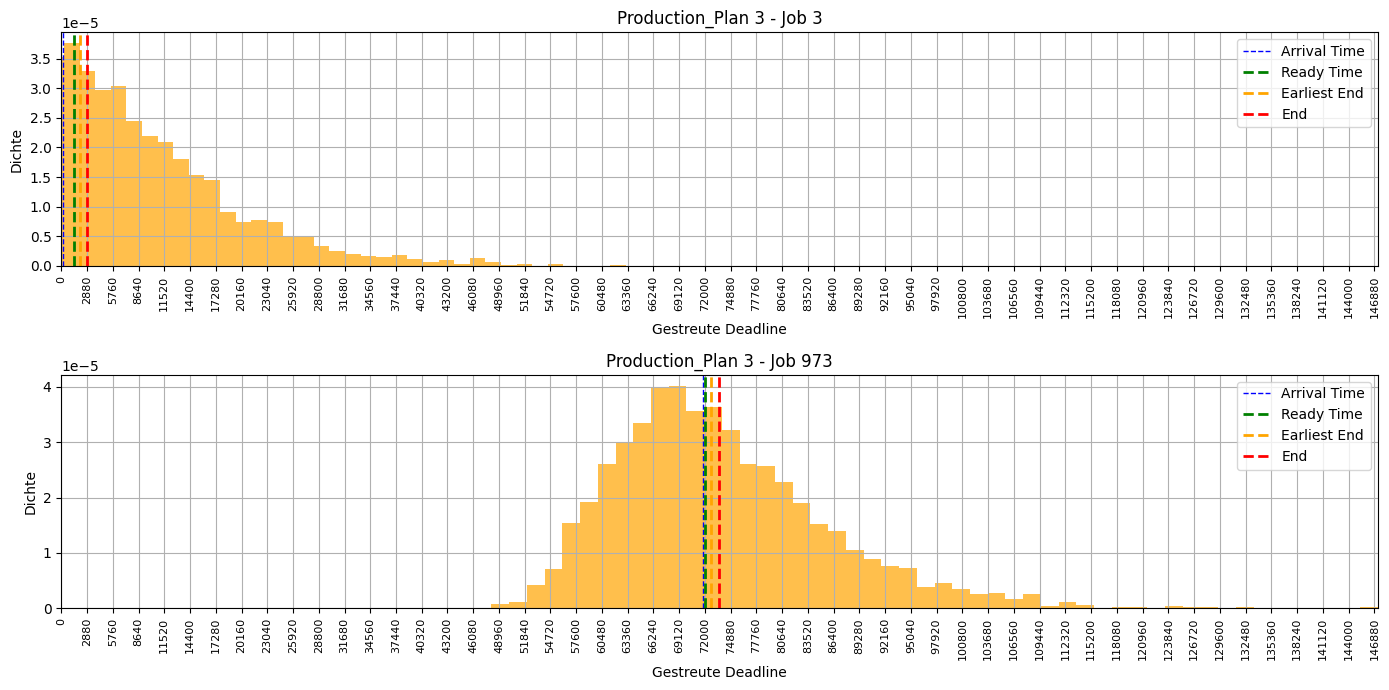

In [13]:
df = add_deadline_list_from_fn(df_jobs_times, base_fn=add_groupwise_lognormal_deadlines,
                                          k=5000, seed=42, sigma=0.3, method="mean")

filt = df.Production_Plan_ID.astype(str).isin(["2"])
plot_random_deadline_distributions( df[filt], n=2)

filt = df.Production_Plan_ID.astype(str).isin(["3"])
plot_random_deadline_distributions( df[filt], n=2)

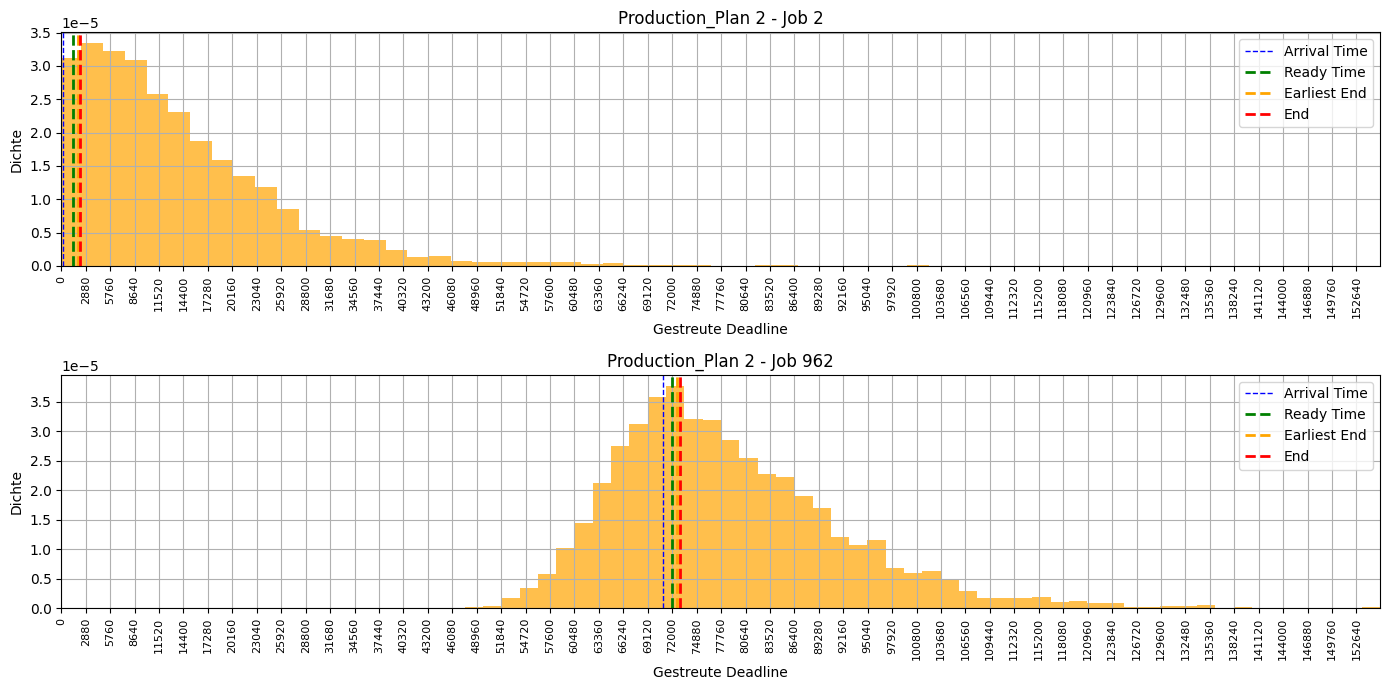

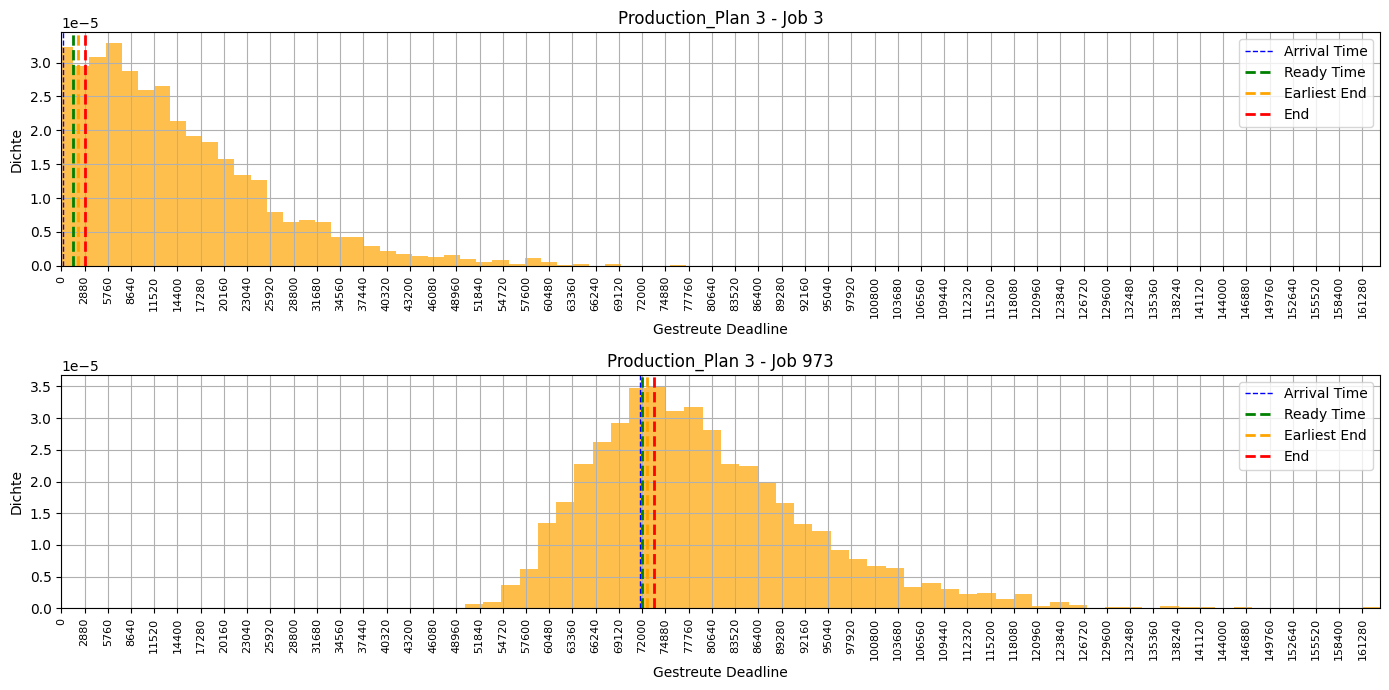

In [14]:
df = add_deadline_list_from_fn(df_jobs_times, base_fn=add_groupwise_lognormal_deadlines,
                                          k=5000, seed=42, sigma=0.3, method="mode")

filt = df.Production_Plan_ID.astype(str).isin(["2"])
plot_random_deadline_distributions( df[filt], n=2)

filt = df.Production_Plan_ID.astype(str).isin(["3"])
plot_random_deadline_distributions( df[filt], n=2)

In [15]:
df_times = add_groupwise_lognormal_deadlines(df_jobs_times, sigma=0.2, method= "mode")
df_times

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,0,0,51,1440,3050.0,395,8791.2
1,1,1,136,1440,2736.0,510,4327.7
2,2,2,158,1440,2258.0,568,6974.5
3,3,3,236,1440,2926.0,655,46.6
4,4,4,404,1440,3007.0,393,-2031.5
5,5,5,485,1440,2731.0,496,20358.9
6,6,6,501,1440,2646.0,416,731.5
7,7,7,528,1440,3085.0,539,8789.9
...,...,...,...,...,...,...,...
969,969,9,71474,72000,73619.0,540,62575.9


In [17]:
df_times.to_csv(basic_data_path / "jobs_times_50_raw_part2.csv", index = False)